In [1]:
import cudaq
from cudaq import spin
import numpy as np
from math import pi
from typing import List
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, NullLocator
import matplotlib.patches as mpatches
import os
import pandas as pd
import pickle

In [2]:
cudaq.register_operation("custom_a", np.array(
    [[0, 1], 
     [0, 0]]
))

In [3]:
cudaq.set_target("orca-photonics")
@cudaq.kernel
def kernel():
    q = qudit(2)
    # h(q)
    # annihilate(q)
    # create(q)

    mz(q)

In [4]:
cudaq.set_target("nvidia")
@cudaq.kernel
def kernel():
    q = cudaq.qvector(2)
    # h(q)
    # custom_a(q[0])
    # y(q)
    x(q)
    rz(0.25*pi, q)

In [5]:
shot = int(1e6)
result = cudaq.sample(kernel, shots_count=shot)

print(result)

{ 11:1000000 }



In [6]:
state = cudaq.get_state(kernel)
a = state.amplitudes(["00","11"])
a = np.array(a, dtype=np.complex128)
print(abs(a))
print(a)

[0.         0.99999998]
[0.        +0.j         0.70710671+0.70710683j]


In [7]:
c = np.array([0.+0j, 0.577350269, 0.577350269, 0., 0., 0., 0., 0., 0.577350269, 0., 0., 0., 0., 0., 0., 0.], dtype=cudaq.complex())
@cudaq.kernel
def kk(cc: List[complex]):
    # a = cudaq.qvector([0.+0j, 0.577350269, 0.577350269, 0., 0., 0., 0., 0., 0.577350269, 0., 0., 0., 0., 0., 0., 0.])
    a = cudaq.qvector(cc)
    # a = cudaq.qvector([0.+0j, 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

    # h(a)
    # exp_pauli(3.14 / 4, a, "IXIX")
    # exp_pauli(3.14 / 4, a, "IYIY")
    
result = cudaq.sample(kk, c, shots_count=int(1e5))
print(result)
print(cudaq.draw(kk, c))

{ 0001:33465 0100:33446 1000:33089 }




In [8]:
coeff = [[0.2, 0.3, 0], [-0.1, 0.4, 1, -0.6, 2], [0.5, 0.7, 3]]
coe = sum(coeff, [])
lenn = [len(c) for c in coeff]
lenn_in = [sum(lenn[:i]) for i in range(len(lenn)+1)]
print(lenn_in)
ccc = [0.2, 0.3, 0]
data = [0.1, 0.2, 0.3, 0.4]

[0, 3, 8, 11]


In [9]:
@cudaq.kernel
def kk2(coeff: List[float], data: List[float]):
    a = cudaq.qvector(1)
    z = coeff[0]
    for i in range(1, len(coeff), 2):
        z += coeff[i] * data[int(coeff[i+1])]
    rz(z, a[0])
print(cudaq.draw(kk2, coeff[2], data))

     ╭──────────╮
q0 : ┤ rz(0.78) ├
     ╰──────────╯



In [10]:
@cudaq.kernel
def kk2(coeffs: List[float], data: List[float], lenn: List[int]):
    a = cudaq.qvector(len(lenn))
    cou = 0
    for s in range(len(lenn)):
        z = coeffs[cou]
        for i in range(1, lenn[s], 2):
            z += coeffs[cou + i] * data[int(coeffs[cou + i + 1])]
        rz(z, a[s])
        cou += lenn[s]

print(cudaq.draw(kk2, coe, data, lenn))

     ╭──────────╮
q0 : ┤ rz(0.23) ├
     ├──────────┤
q1 : ┤ rz(-0.2) ├
     ├──────────┤
q2 : ┤ rz(0.78) ├
     ╰──────────╯



In [11]:
@cudaq.kernel
def k_exp_pauli():
    q = cudaq.qvector(4)
    rz(1, q)
    exp_pauli(1, q, "YYIZ")

print(cudaq.draw(k_exp_pauli))

     ╭───────╮╭───────────╮                              ╭────────────╮
q0 : ┤ rz(1) ├┤ rx(1.571) ├──●────────────────────────●──┤ rx(-1.571) ├
     ├───────┤├───────────┤╭─┴─╮                    ╭─┴─╮├────────────┤
q1 : ┤ rz(1) ├┤ rx(1.571) ├┤ x ├──●──────────────●──┤ x ├┤ rx(-1.571) ├
     ├───────┤╰───────────╯╰───╯  │              │  ╰───╯╰────────────╯
q2 : ┤ rz(1) ├────────────────────┼──────────────┼─────────────────────
     ├───────┤                  ╭─┴─╮╭────────╮╭─┴─╮                   
q3 : ┤ rz(1) ├──────────────────┤ x ├┤ rz(-2) ├┤ x ├───────────────────
     ╰───────╯                  ╰───╯╰────────╯╰───╯                   



In [12]:
def box_plot(data, idx, color, width):
    ax = plt.gca()
    bp = ax.boxplot(data, positions=idx, patch_artist=True, widths=width, manage_ticks=False)
    # print(bp.keys)
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=color)

    plt.setp(bp['fliers'], markerfacecolor=color, markeredgecolor=color, alpha=0.6)

    for patch in bp['boxes']:
        patch.set(facecolor=color, alpha=0.3)
        
    return bp
def validate_qubit_assets_numBases(num_qubits, num_assets, num_bases):
    if num_bases == 3:
        return True if num_qubits >= 4 else False
    elif num_bases == 6:
        return True if num_qubits >= 5 else False
    elif num_bases == 12:
        return True if num_qubits >= 8 or (num_qubits == 7 and num_assets <= 3) else False
    elif num_bases == 25:
        return True if num_qubits >= 11 or (num_qubits == 10 and num_assets <= 4) or (num_qubits == 9 and num_assets <= 3) else False
    
# for b in [3, 6, 12, 25]:
#     for q in range(4, 13):
#         for a in range(3, 6):
#             print(f"Qubits: {q}, Assets: {a}, Bases: {b} -> {validate_qubit_assets_numBases(q, a, b)}")
#     print() 

7


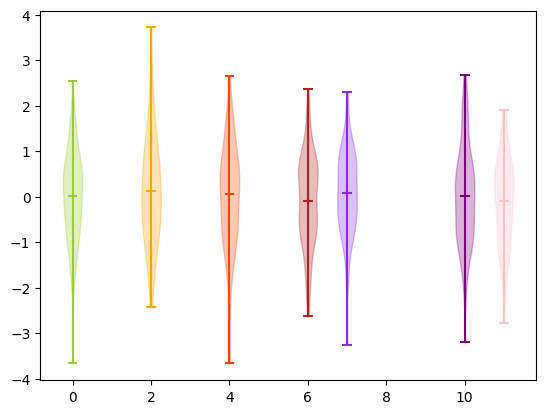

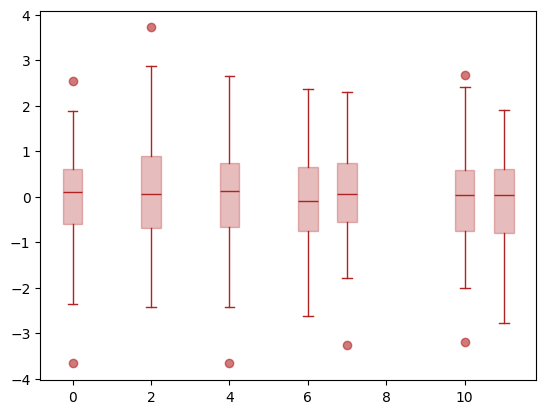

In [13]:
rd = np.random.randn(100, 7)
color_map = {(3, 'Preserving'): "yellowgreen",
                (6, 'Preserving'): "orange",
                (12, 'Preserving'): "orangered",
                (25, 'Preserving'): "firebrick",
                ("H_space", "X"): "blueviolet"}

color_l = ["yellowgreen", "orange", "orangered", "firebrick", "blueviolet", "purple",  "pink"]
# color_ll = ["#ADFF2F", "#FFA500", "#FF4500", "#B22222", "#8A2BE2", "#800080", "#FFC0CB"]


idx = np.array([0, 2, 4, 6, 7, 10, 11])
vplot = plt.violinplot(rd, idx, showmeans=True)
# plt.show()
print(len(vplot["bodies"]))

for pn in vplot.keys():
    vp = vplot[pn]
    if pn == "bodies":
        for i in range(len(vplot["bodies"])):
            vp[i].set_facecolor(color_l[i])
            vp[i].set_edgecolor(color_l[i])
    else:
        vp.set_edgecolor(color_l)
plt.show()

bp1 = box_plot(rd, idx, 'firebrick', 0.5)
plt.show()

# for i in range(len(vplot["bodies"])):
#     vplot["bodies"][i].set_facecolor(color_l[i])
#     vplot["bodies"][i].set_edgecolor(color_l[i])
    # vplot["bodies"][i].set_edgecolor("black")


# Approx and MaxProb Ratio plot

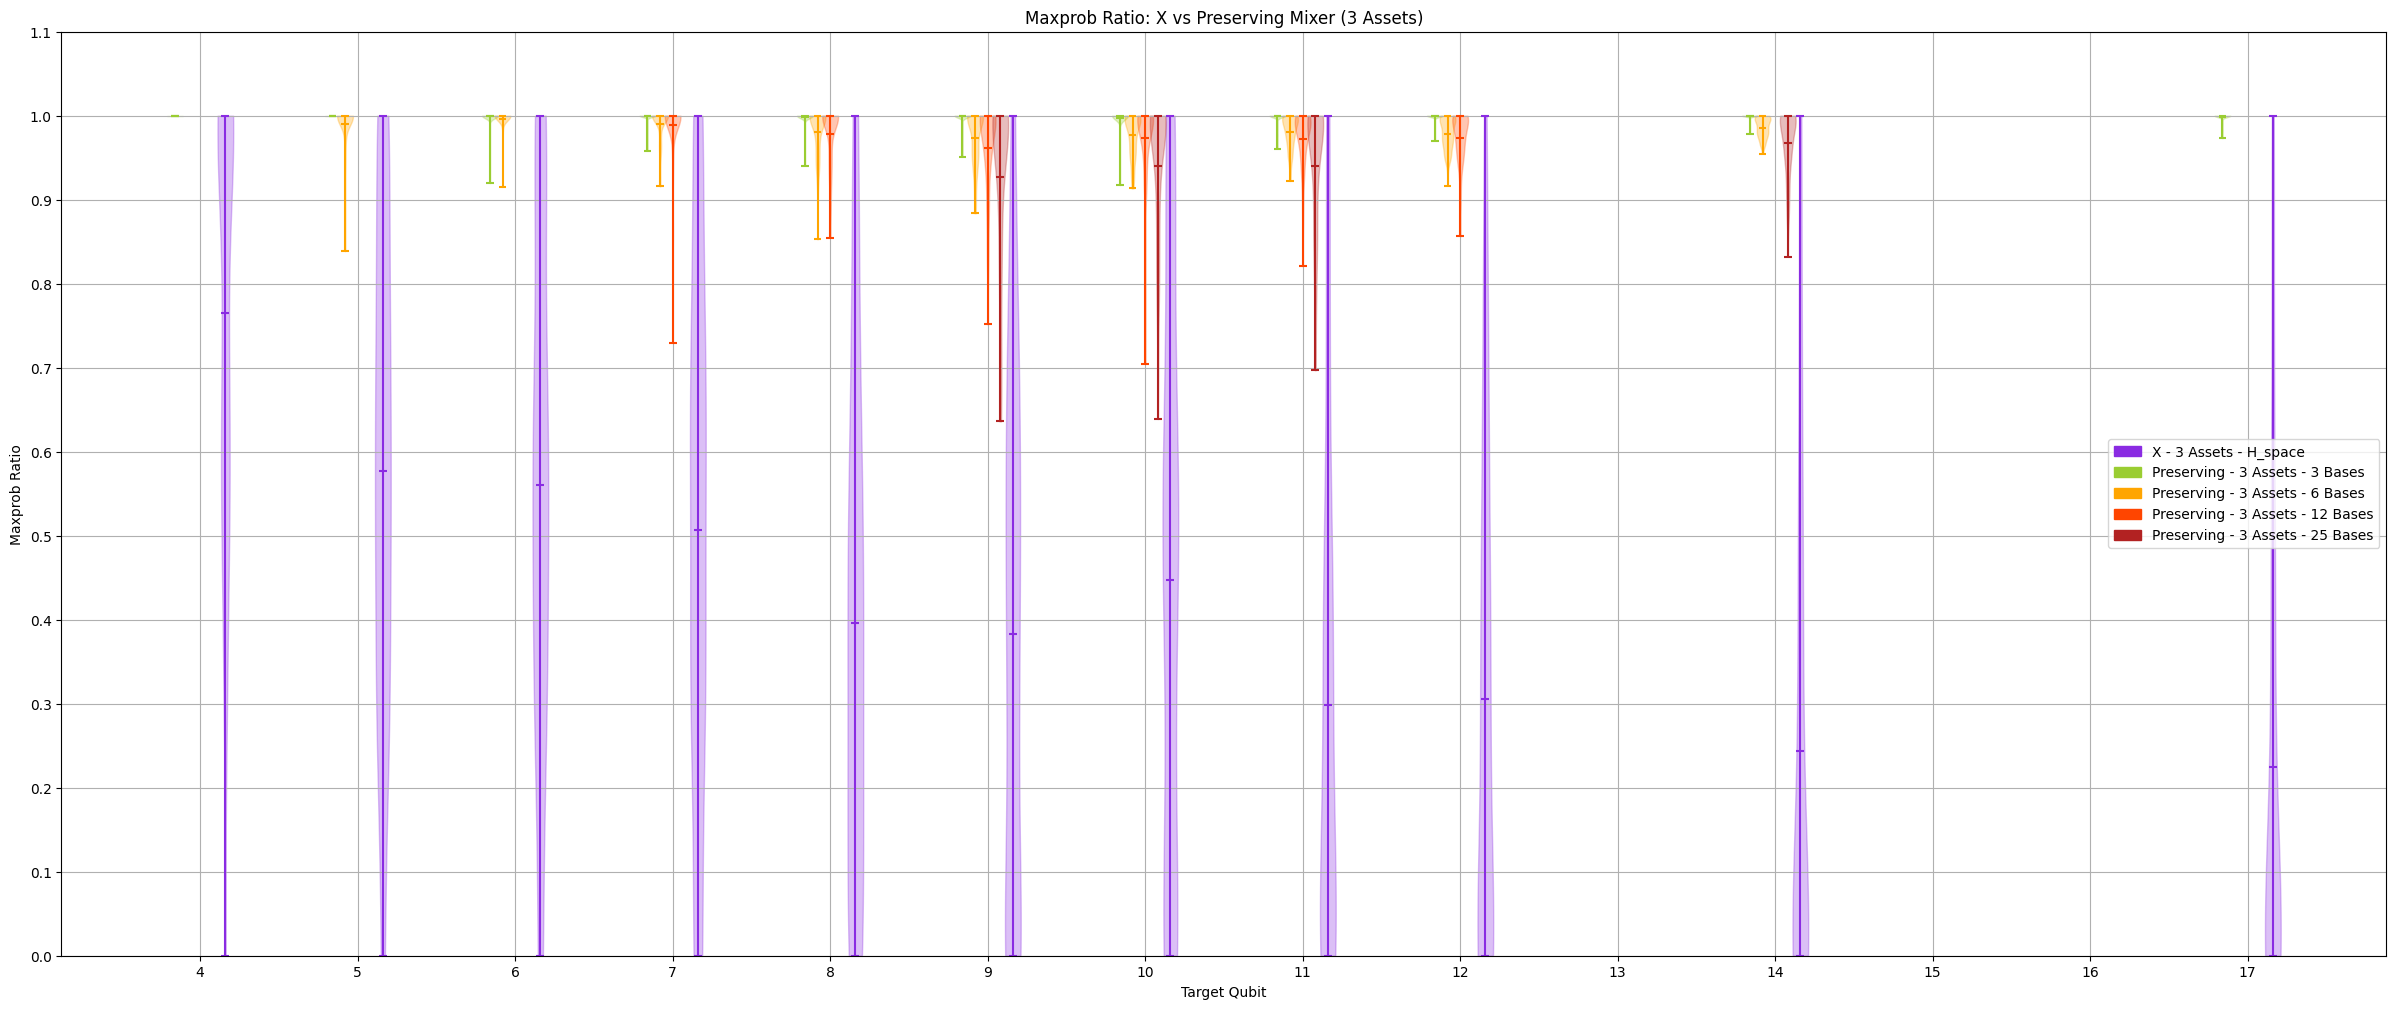

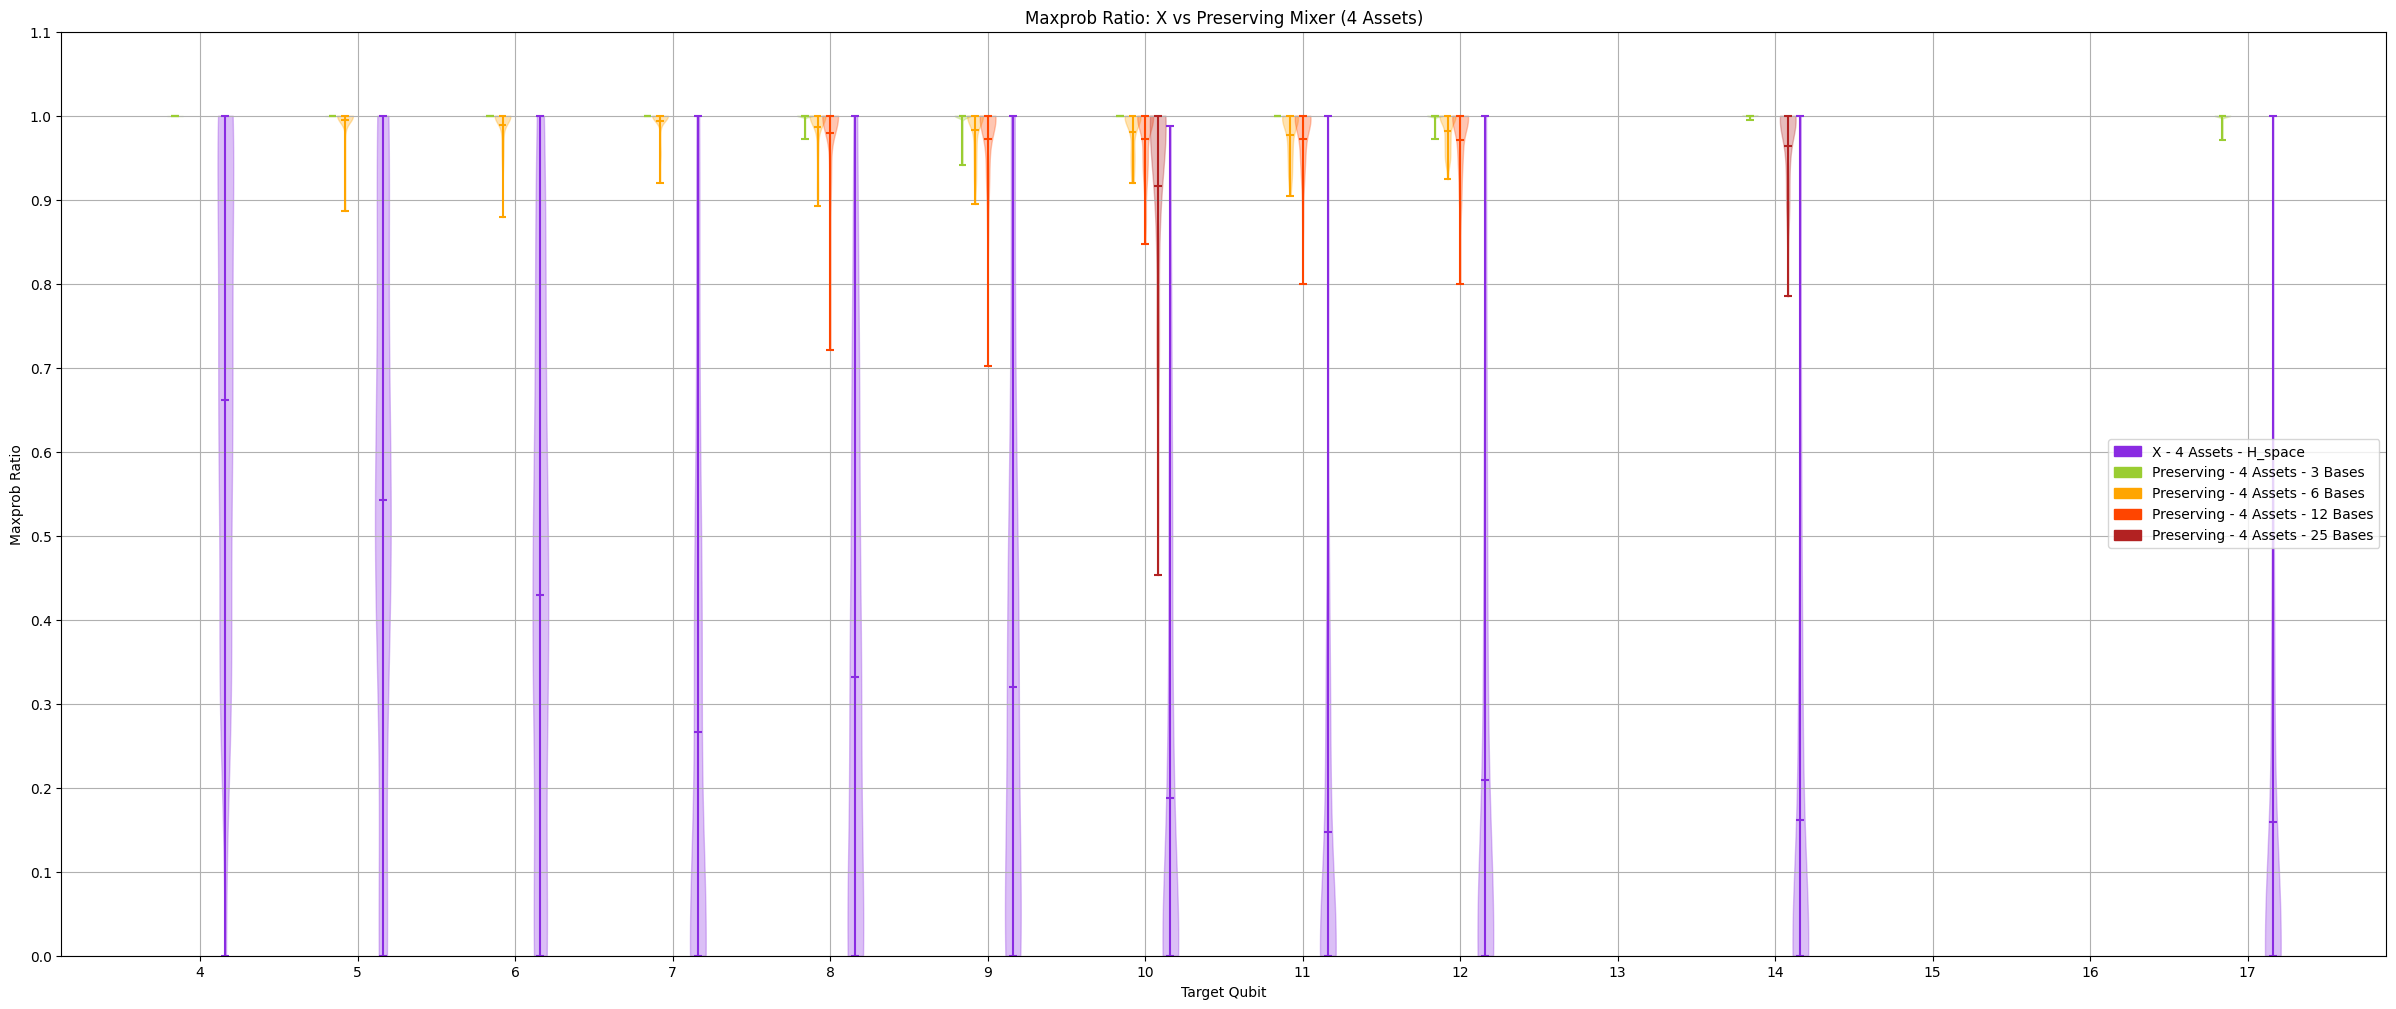

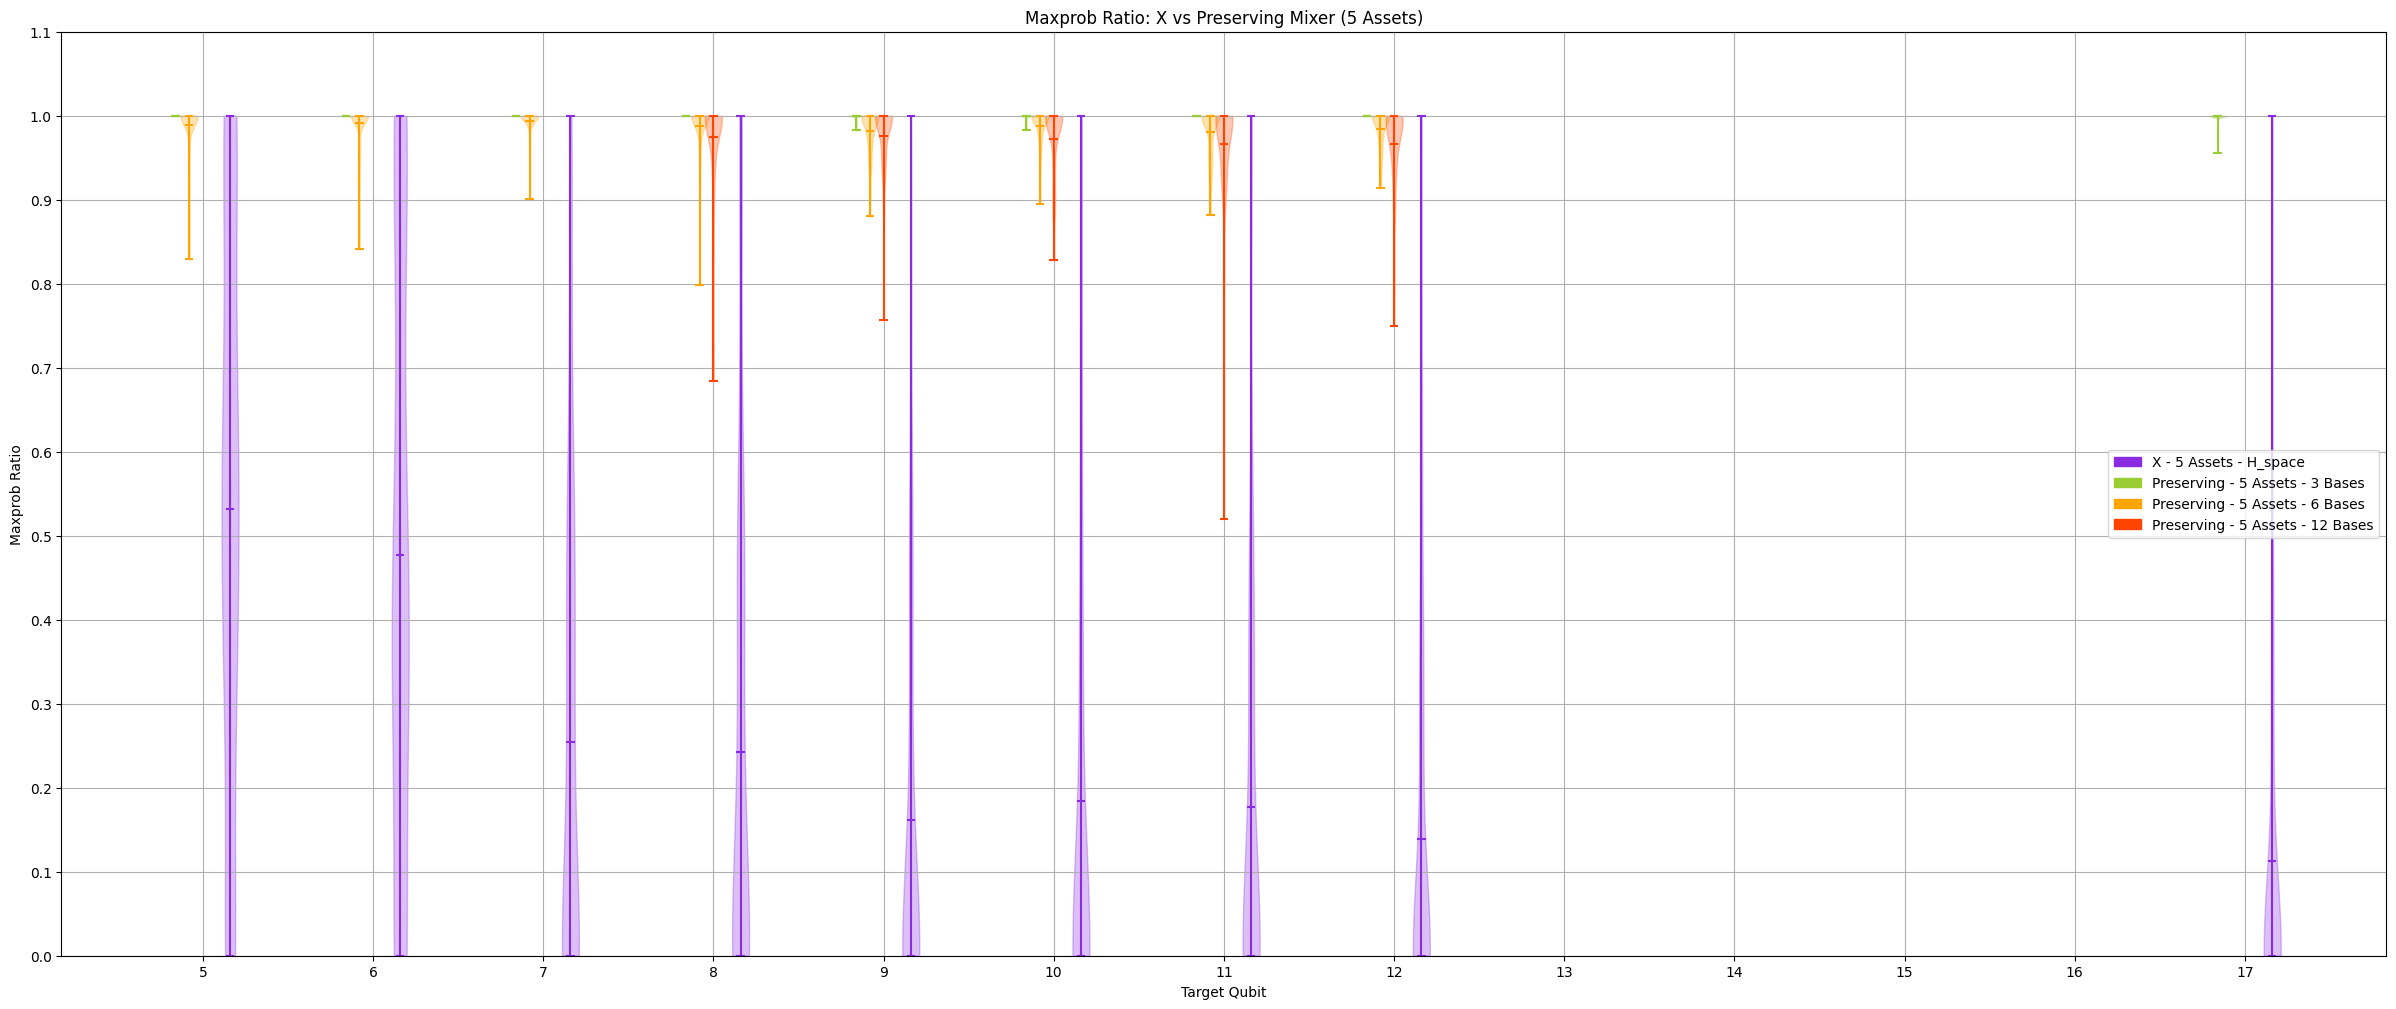

In [14]:
modes = ["X", "Preserving"]
LAMB = 4  # Budget Penalty
Q = 0  # Volatility Weight
diff = 0.08
diff_idx = np.array([2, -2, -1, 0, 1])
marker_map = {3: "^", 4: "s", 5: "p"}
color_map = {(3, 'Preserving'): "yellowgreen",
                (6, 'Preserving'): "orange",
                (12, 'Preserving'): "orangered",
                (25, 'Preserving'): "firebrick",
                ("H_space", "X"): "blueviolet"}
line_map = {"X": ":", "Preserving": "-"}
plot_mode = ["Approximate_ratio", "MaxProb_ratio"][1]
for N_ASSETS in range(3, 6):
    legend_handles = []
    plt.figure(figsize=(30, 12))
    cou = 0
    for mode in modes:
        for num_init_bases in (["H_space"] if mode == "X" else [3, 6, 12, 25]):
            mode_results = []
            range_qubit = []
            for TARGET_QUBIT in range(4, 20):
                if mode == "Preserving" and not validate_qubit_assets_numBases(TARGET_QUBIT, N_ASSETS, num_init_bases):
                    continue
                dir_name = f"exp_Q{TARGET_QUBIT}_A{N_ASSETS}_L{LAMB}_q{Q}_B{3 if mode == 'X' else num_init_bases}"
                dir_path = f"./experiments/{dir_name}"
                if not os.path.exists(f"{dir_path}/result.csv"):
                    continue
                df = pd.read_csv(f"{dir_path}/result.csv")
                df_raw = pd.read_csv(f"{dir_path}/{mode}.csv")
                mode_result = df[df["Mode"] == mode][plot_mode].values[0]
                points = np.array(df_raw[plot_mode])
                # mode_results.append(mode_result)
                mode_results.append(points)
                # print(points.shape)
                range_qubit.append(TARGET_QUBIT)
            # plt.plot(range_qubit, mode_results, marker=marker_map[N_ASSETS], color=color_map[(num_init_bases, mode)], linestyle=line_map[mode], label=f"{mode} - {N_ASSETS} Assets - {num_init_bases}{'' if mode == 'X' else ' Bases'}", markersize=8)
            # mode_result = np.array(mode_results)
            range_qubit = np.array(range_qubit) + diff * diff_idx[cou]
            # print(mode_result.shape, range_qubit.shape)
            if len(mode_results) == 0:
                continue
            # print(mode, num_init_bases, mode_result.shape)
            vplot = plt.violinplot(mode_results, range_qubit, showmeans=True, widths=0.1)
            # print(len(vplot["bodies"]))
            color_now = color_map[(num_init_bases, mode)]
            for i in range(len(vplot["bodies"])):
                vplot["bodies"][i].set_facecolor(color_now)
                vplot["bodies"][i].set_edgecolor(color_now)
            for pn in vplot.keys():
                vp = vplot[pn]
                if pn != "bodies":
                    vp.set_edgecolor(color_now)
            label = f"{mode} - {N_ASSETS} Assets - {num_init_bases}{'' if mode == 'X' else ' Bases'}"
            patch = mpatches.Patch(color=color_now, label=label)
            legend_handles.append(patch)

            cou += 1
    plt.xlabel("Target Qubit")
    plt.ylabel(plot_mode.replace("_", " ").title())
    plt.title(f"{plot_mode.replace('_', ' ').title()}: X vs Preserving Mixer ({N_ASSETS} Assets)")
    # plt.legend()
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles=legend_handles, loc="best")
    plt.ylim(0, 1.01)
    plt.grid()
    ax = plt.gca()
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.set_xticks(np.arange(int(np.ceil(xmin)), int(np.floor(xmax)) + 1))
    ax.set_yticks(np.arange(np.floor(ymin*10)/10, np.ceil(ymax*10)/10 + 0.05, 0.1))
    plt.show()

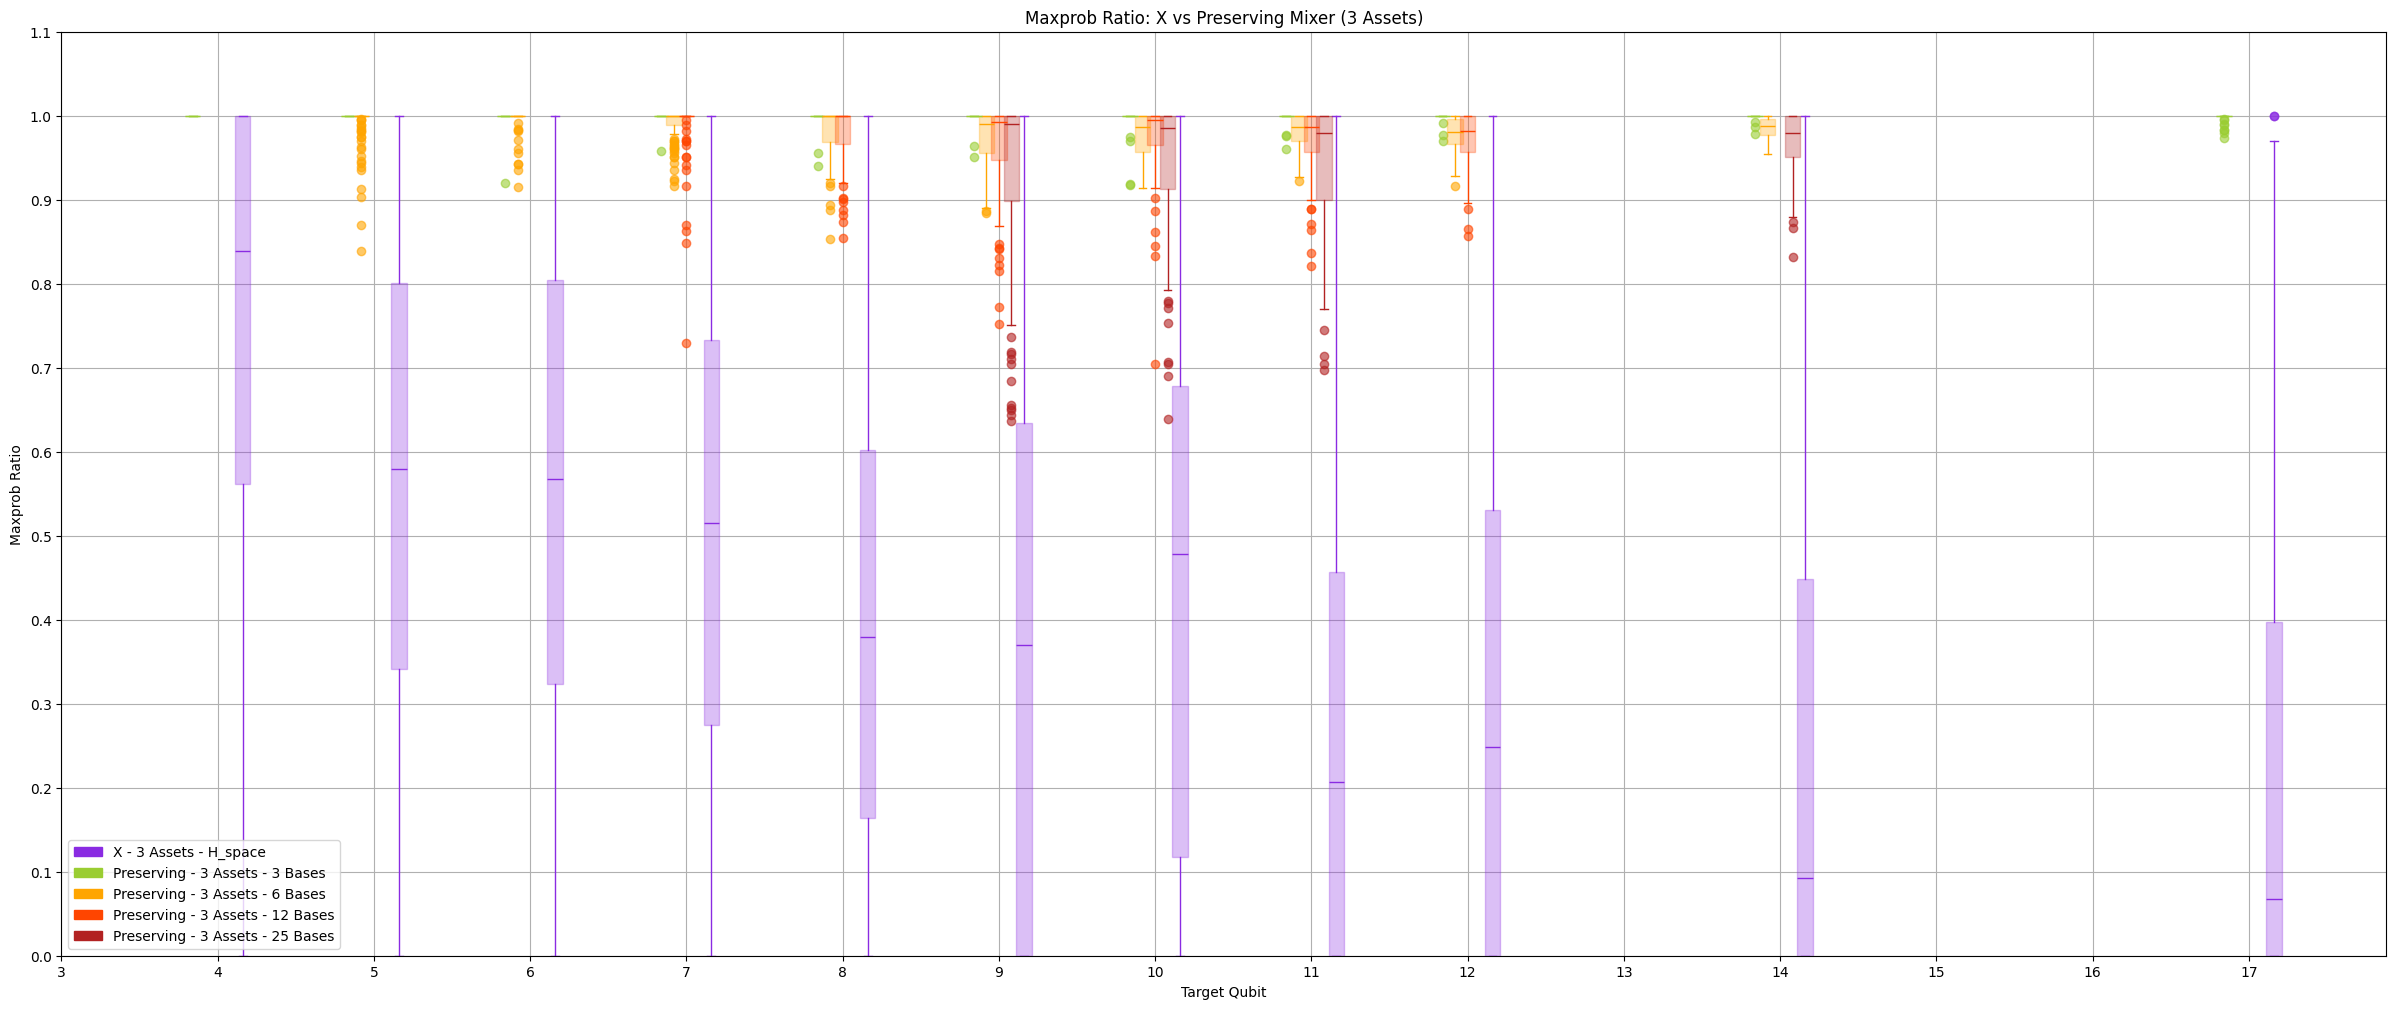

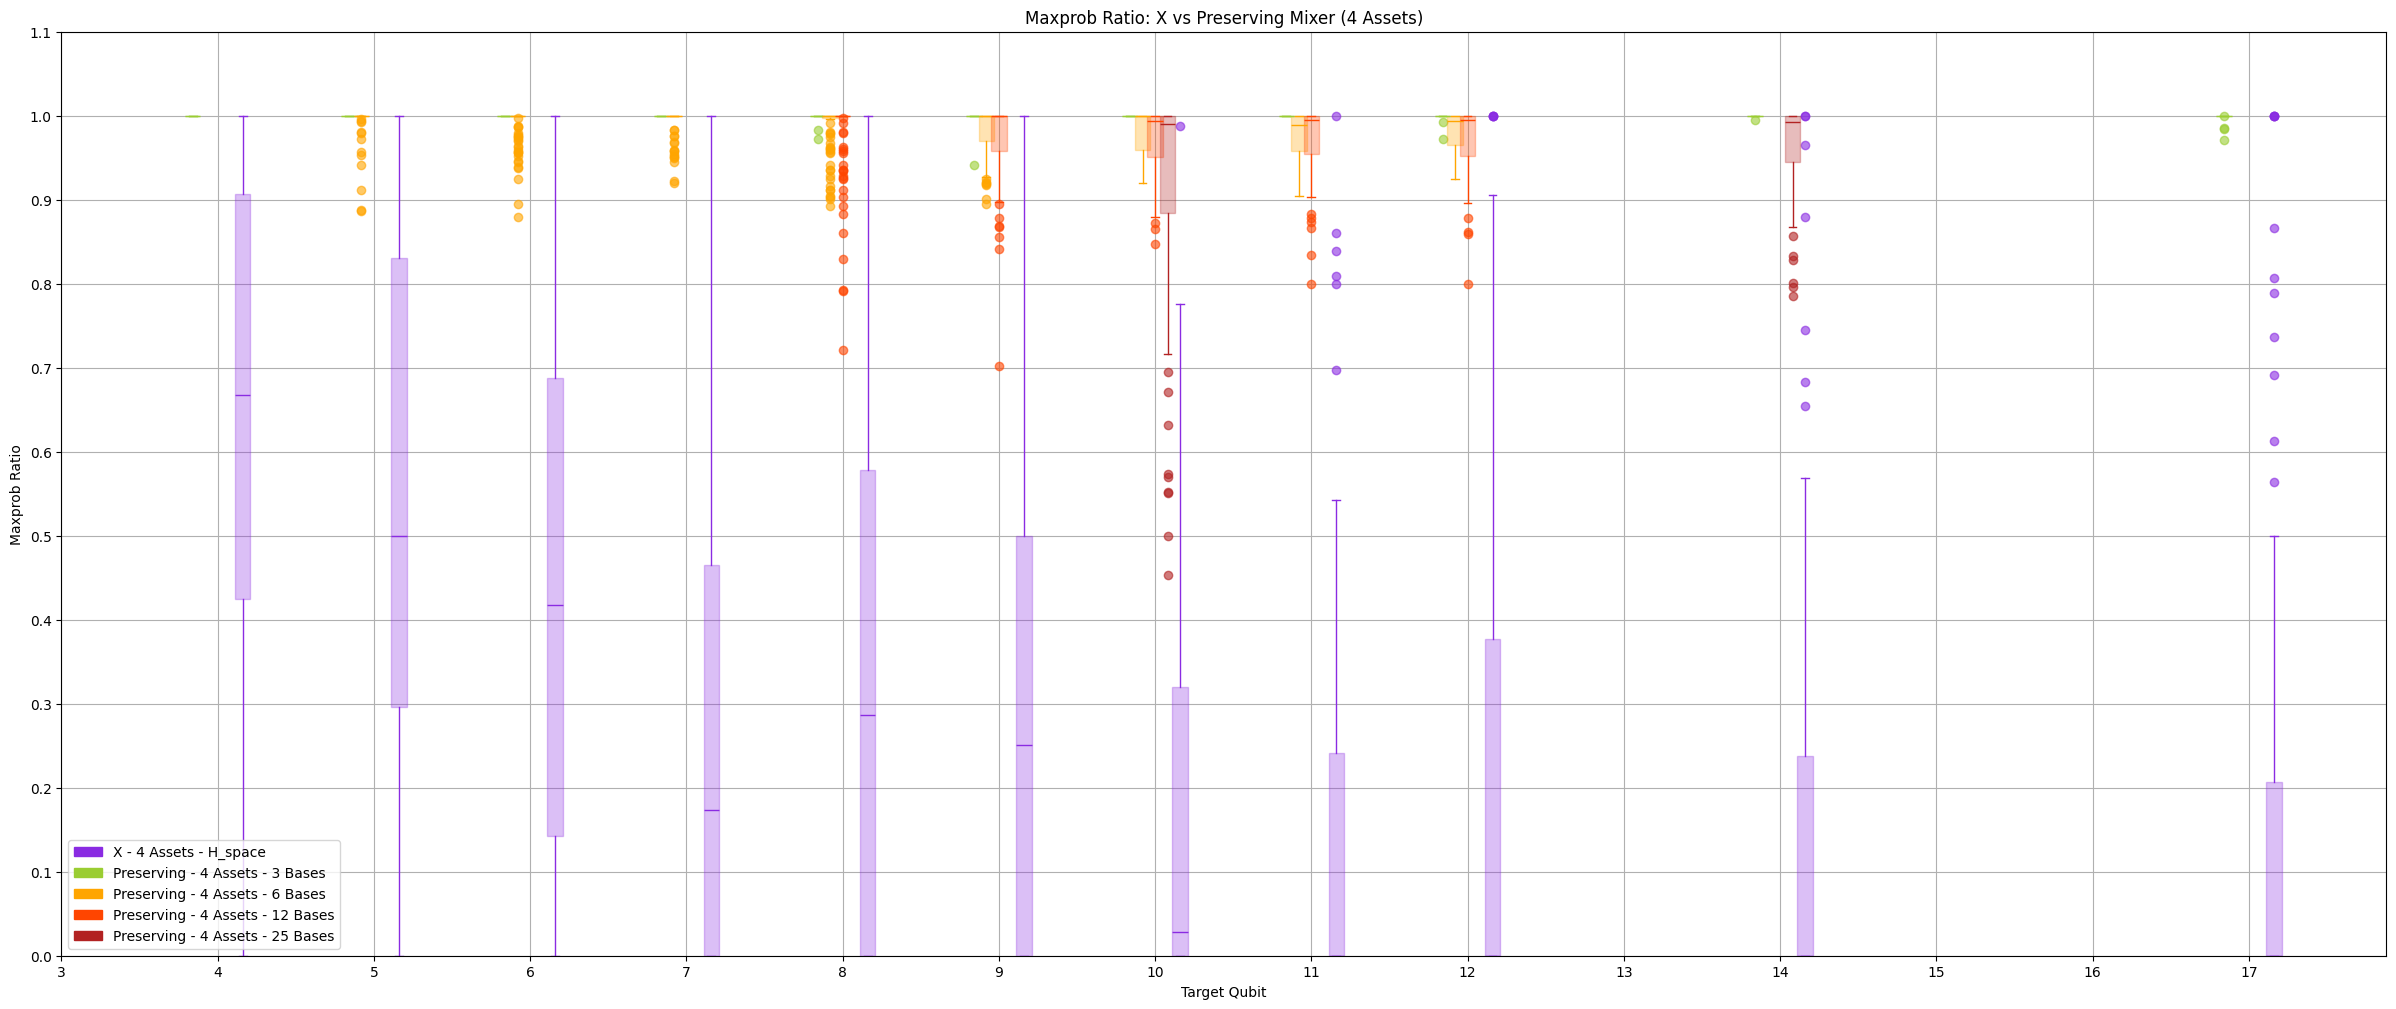

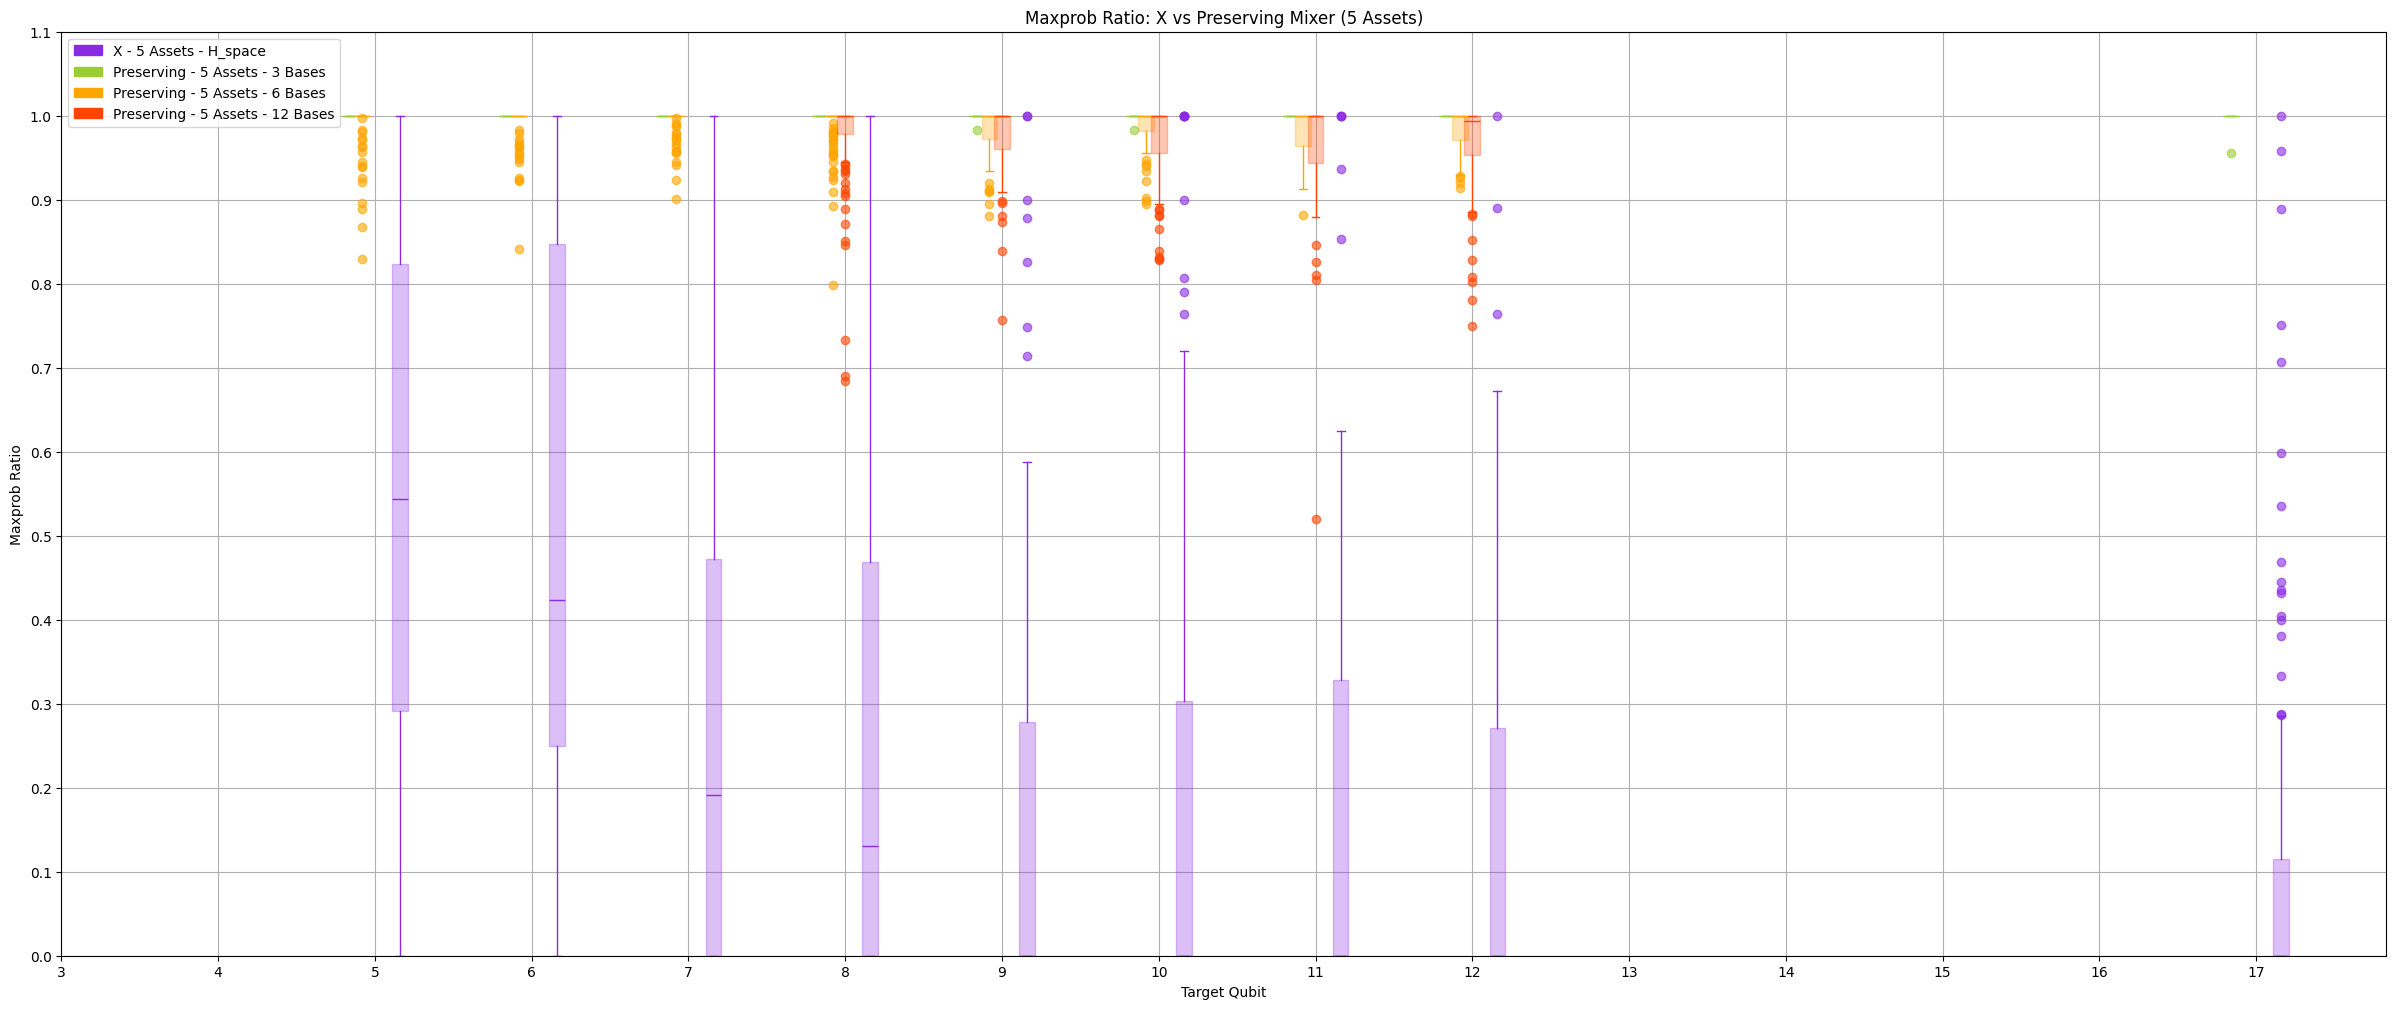

In [15]:
modes = ["X", "Preserving"]
LAMB = 4  # Budget Penalty
Q = 0  # Volatility Weight
diff = 0.08
diff_idx = np.array([2, -2, -1, 0, 1])
marker_map = {3: "^", 4: "s", 5: "p"}
color_map = {(3, 'Preserving'): "yellowgreen",
                (6, 'Preserving'): "orange",
                (12, 'Preserving'): "orangered",
                (25, 'Preserving'): "firebrick",
                ("H_space", "X"): "blueviolet"}
line_map = {"X": ":", "Preserving": "-"}
plot_mode = ["Approximate_ratio", "MaxProb_ratio"][1]
for N_ASSETS in range(3, 6):
    legend_handles = []
    plt.figure(figsize=(30, 12))
    cou = 0
    for mode in modes:
        for num_init_bases in (["H_space"] if mode == "X" else [3, 6, 12, 25]):
            mode_results = []
            range_qubit = []
            for TARGET_QUBIT in range(4, 20):
                if mode == "Preserving" and not validate_qubit_assets_numBases(TARGET_QUBIT, N_ASSETS, num_init_bases):
                    continue
                dir_name = f"exp_Q{TARGET_QUBIT}_A{N_ASSETS}_L{LAMB}_q{Q}_B{3 if mode == 'X' else num_init_bases}"
                dir_path = f"./experiments/{dir_name}"
                if not os.path.exists(f"{dir_path}/result.csv"):
                    continue
                df = pd.read_csv(f"{dir_path}/result.csv")
                df_raw = pd.read_csv(f"{dir_path}/{mode}.csv")
                mode_result = df[df["Mode"] == mode][plot_mode].values[0]
                points = np.array(df_raw[plot_mode])
                # mode_results.append(mode_result)
                mode_results.append(points)
                # print(points.shape)
                range_qubit.append(TARGET_QUBIT)
            # plt.plot(range_qubit, mode_results, marker=marker_map[N_ASSETS], color=color_map[(num_init_bases, mode)], linestyle=line_map[mode], label=f"{mode} - {N_ASSETS} Assets - {num_init_bases}{'' if mode == 'X' else ' Bases'}", markersize=8)
            # mode_result = np.array(mode_results)
            range_qubit = np.array(range_qubit) + diff * diff_idx[cou]
            # print(mode_result.shape, range_qubit.shape)
            if len(mode_results) == 0:
                continue

            box_plot(mode_results, range_qubit, color_map[(num_init_bases, mode)], width=0.1)
            label = f"{mode} - {N_ASSETS} Assets - {num_init_bases}{'' if mode == 'X' else ' Bases'}"
            patch = mpatches.Patch(color=color_map[(num_init_bases, mode)], label=label)
            legend_handles.append(patch)
            cou += 1
    plt.xlabel("Target Qubit")
    plt.ylabel(plot_mode.replace("_", " ").title())
    plt.title(f"{plot_mode.replace('_', ' ').title()}: X vs Preserving Mixer ({N_ASSETS} Assets)")
    # plt.legend()
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles=legend_handles, loc="best")
    plt.ylim(0, 1.01)
    plt.xlim(3)
    plt.grid()
    ax = plt.gca()
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    # print(xmin)
    ax.set_xticks(np.arange(int(np.ceil(xmin)), int(np.floor(xmax)) + 1))
    ax.set_yticks(np.arange(np.floor(ymin*10)/10, np.ceil(ymax*10)/10 + 0.05, 0.1))
    plt.show()

# Loss Landscape Variation plot

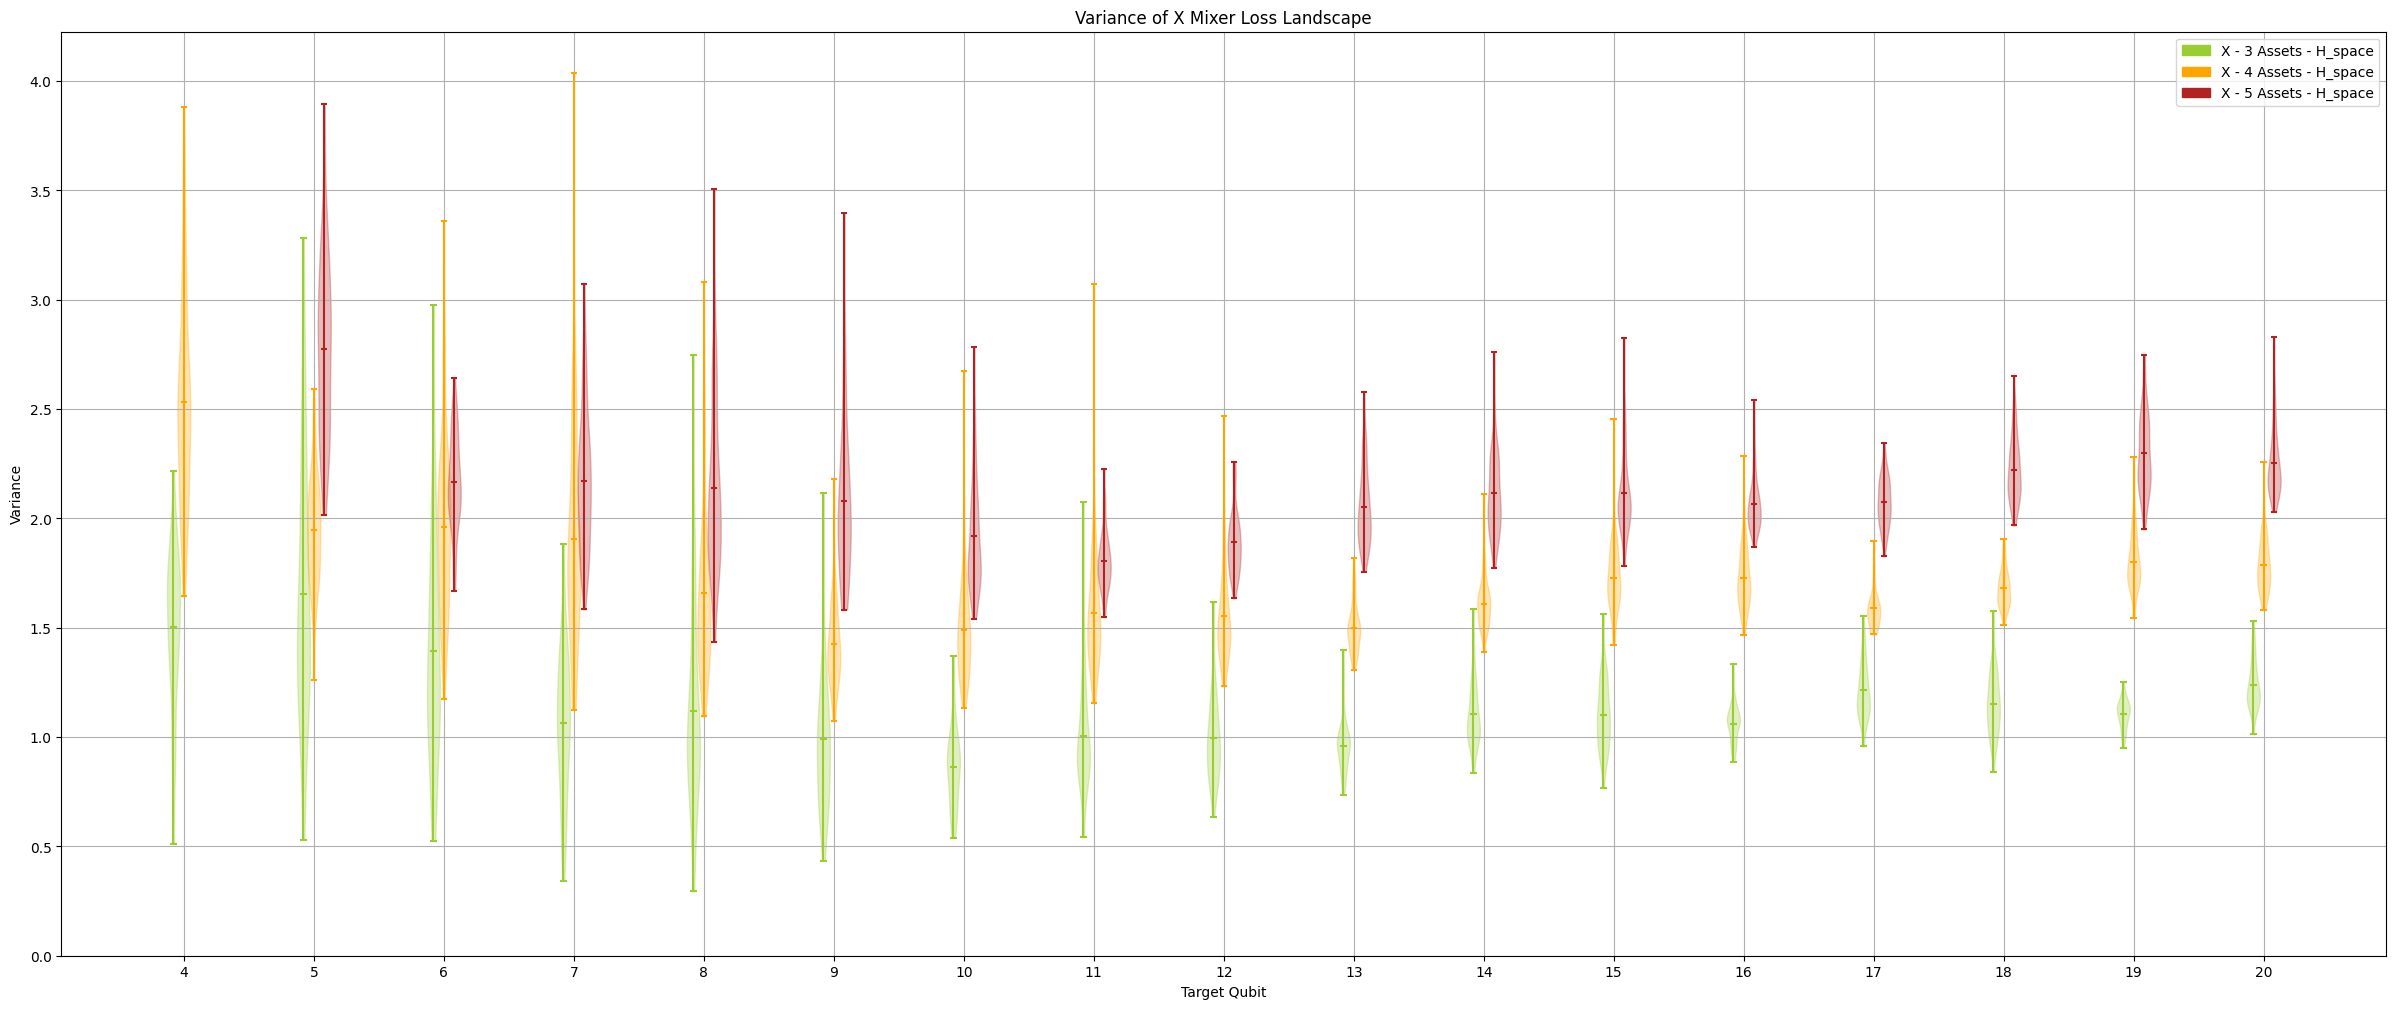

In [22]:
IS_LOG = True
modes = ["X"]
num_init_bases = "H_space"
LAMB = 4  # Budget Penalty
Q = 0  # Volatility Weight
ddof = 1
diff = 0.08
diff_idx = np.array([-1, 0, 1])
marker_map = {3: "^", 4: "s", 5: "p"}
color_map = {3: "yellowgreen",
             4: "orange",
             5: "firebrick"}
line_map = {"X": ":", "Preserving": "-"}
plot_mode = "Variance"
legend_handles = []
plt.figure(figsize=(30, 12))
cou = 0
for N_ASSETS in range(3, 6):
    for mode in modes:
        mode_results = []
        range_qubit = []
        for TARGET_QUBIT in range(4, 21):
            dir_name = f"exp_Q{TARGET_QUBIT}_A{N_ASSETS}_L{LAMB}_q{Q}"
            dir_path = f"./experiments_plateau/{dir_name}"
            # print(dir_path+"/report.csv")
            if not os.path.exists(f"{dir_path}/report.csv"):
                continue
            # print(dir_path) 
            df_raw = pd.read_csv(f"{dir_path}/report.csv")
            N = np.array(df_raw["N"])
            sum_1 = np.array(df_raw["Sum_1"])
            sum_2 = np.array(df_raw["Sum_2"])
            # print(aa_sum2 / (N - ddof) - aa_sum**2 / (N * (N - ddof)))
            var = sum_2 / (N - ddof) - sum_1**2 / (N * (N - ddof))
            # mode_results.append(mode_result)
            if IS_LOG:
                var = np.log(var)
            mode_results.append(var)
            # print(var.shape)
            range_qubit.append(TARGET_QUBIT)
        # plt.plot(range_qubit, mode_results, marker=marker_map[N_ASSETS], color=color_map[(num_init_bases, mode)], linestyle=line_map[mode], label=f"{mode} - {N_ASSETS} Assets - {num_init_bases}{'' if mode == 'X' else ' Bases'}", markersize=8)
        # mode_result = np.array(mode_results)
        range_qubit = np.array(range_qubit) + diff * diff_idx[cou]
        if len(mode_results) == 0:
            continue
        # print(mode, num_init_bases, mode_result.shape)
        vplot = plt.violinplot(mode_results, range_qubit, showmeans=True, widths=0.1)
        # print(len(vplot["bodies"]))
        color_now = color_map[N_ASSETS]
        for i in range(len(vplot["bodies"])):
            vplot["bodies"][i].set_facecolor(color_now)
            vplot["bodies"][i].set_edgecolor(color_now)
        for pn in vplot.keys():
            vp = vplot[pn]
            if pn != "bodies":
                vp.set_edgecolor(color_now)
        label = f"{mode} - {N_ASSETS} Assets - {num_init_bases}{'' if mode == 'X' else ' Bases'}"
        patch = mpatches.Patch(color=color_now, label=label)
        legend_handles.append(patch)
        cou += 1

plt.xlabel("Target Qubit")
plt.ylabel(plot_mode.replace("_", " ").title())
plt.title(f"{plot_mode.replace('_', ' ').title()} of X Mixer Loss Landscape")
# plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=legend_handles, loc="best")
plt.ylim(0)
plt.grid()
ax = plt.gca()
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_xticks(np.arange(int(np.ceil(xmin)), int(np.floor(xmax)) + 1))
# ax.set_yticks(np.arange(np.floor(ymin*0.2)/0.2, np.ceil(ymax*0.2)/0.2 + 5, 5))
plt.show()

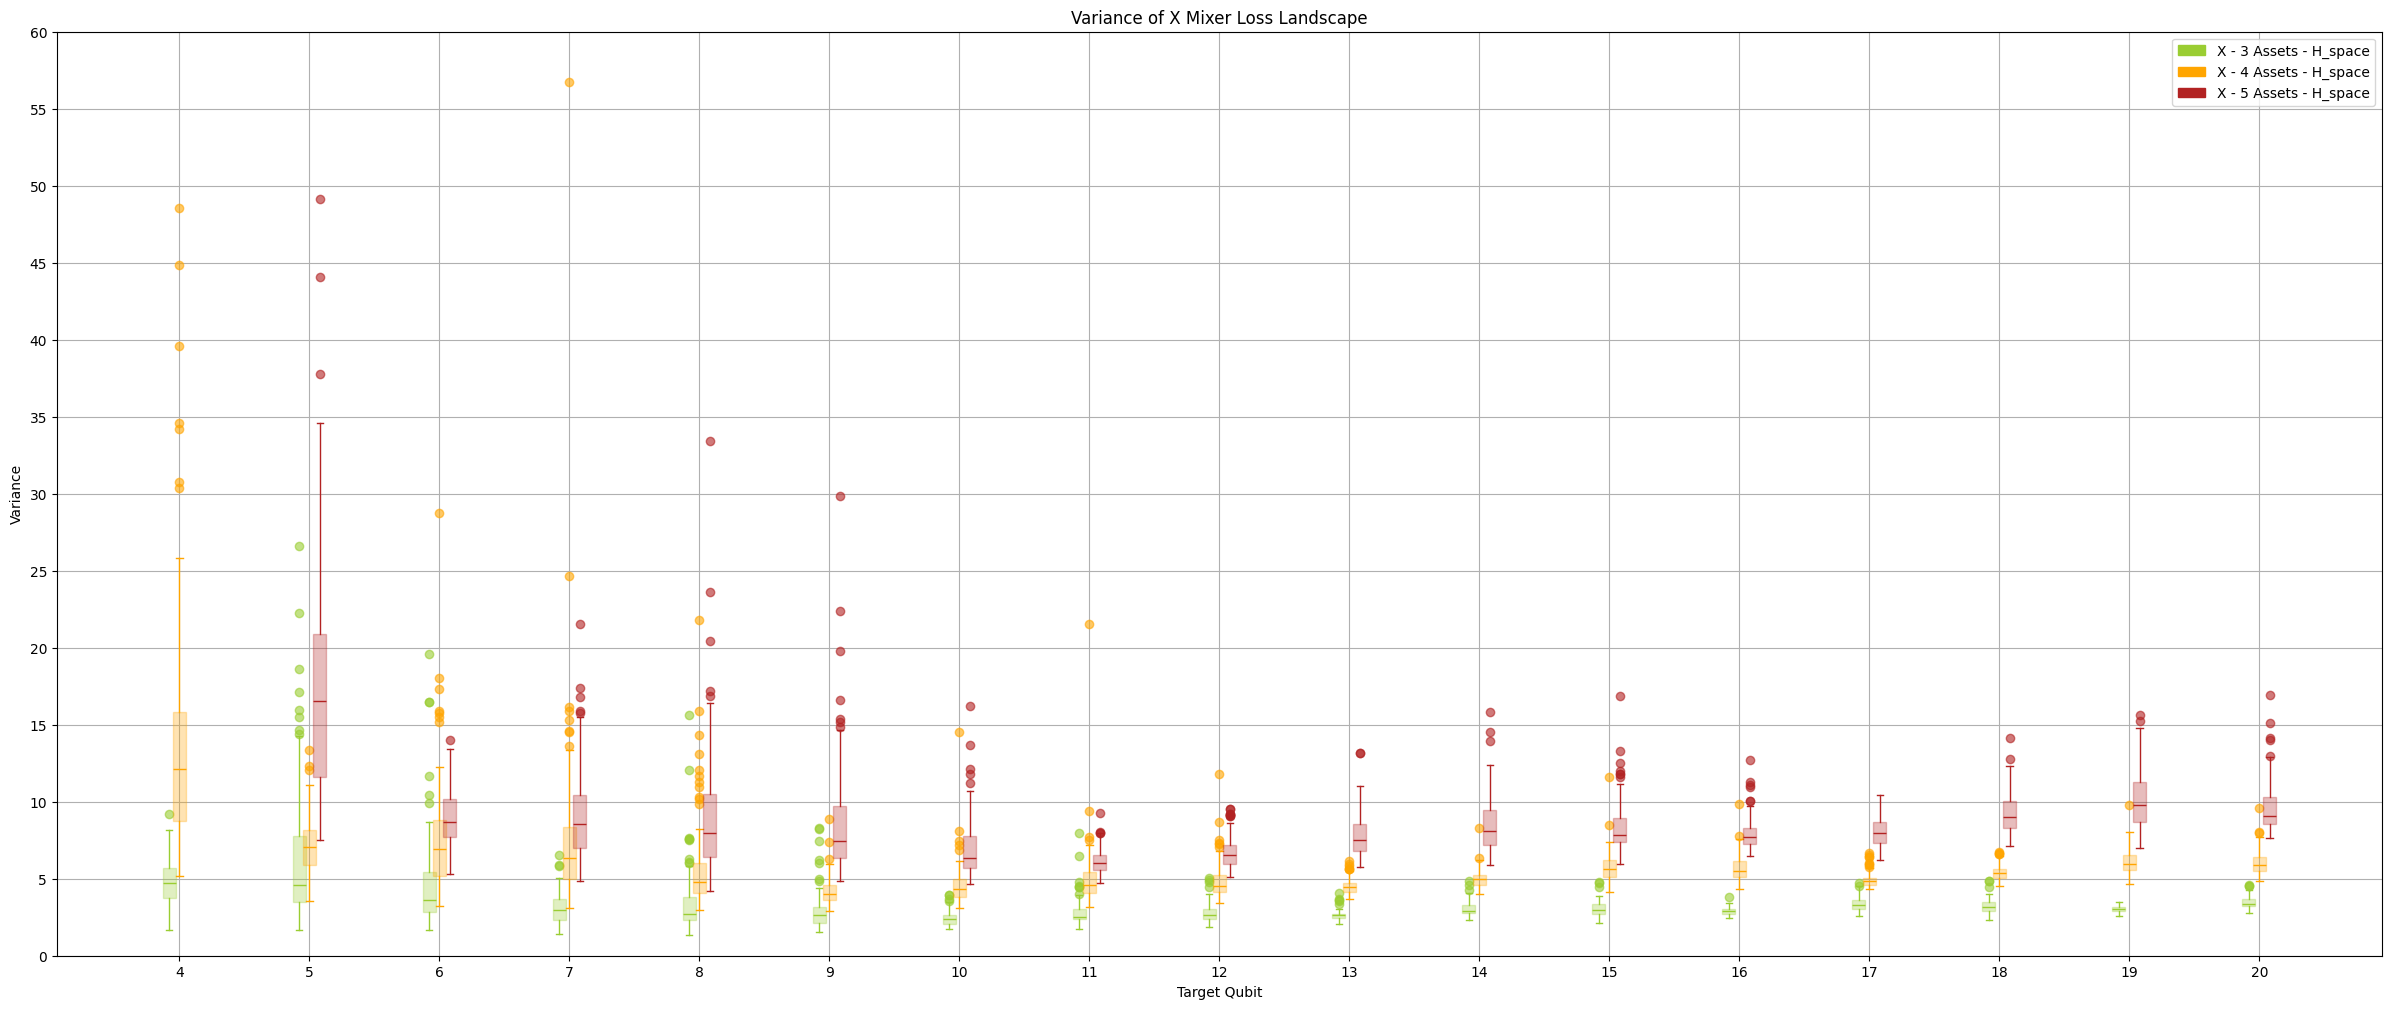

In [23]:
IS_LOG = True
modes = ["X"]
num_init_bases = "H_space"
LAMB = 4  # Budget Penalty
Q = 0  # Volatility Weight
ddof = 1
diff = 0.08
diff_idx = np.array([-1, 0, 1])
marker_map = {3: "^", 4: "s", 5: "p"}
color_map = {3: "yellowgreen",
             4: "orange",
             5: "firebrick"}
line_map = {"X": ":", "Preserving": "-"}
plot_mode = "Variance"
legend_handles = []
plt.figure(figsize=(30, 12))
cou = 0
for N_ASSETS in range(3, 6):
    for mode in modes:
        mode_results = []
        range_qubit = []
        for TARGET_QUBIT in range(4, 21):
            dir_name = f"exp_Q{TARGET_QUBIT}_A{N_ASSETS}_L{LAMB}_q{Q}"
            dir_path = f"./experiments_plateau/{dir_name}"
            # print(dir_path+"/report.csv")
            if not os.path.exists(f"{dir_path}/report.csv"):
                continue
            # print(dir_path) 
            df_raw = pd.read_csv(f"{dir_path}/report.csv")
            N = np.array(df_raw["N"])
            sum_1 = np.array(df_raw["Sum_1"])
            sum_2 = np.array(df_raw["Sum_2"])
            # print(aa_sum2 / (N - ddof) - aa_sum**2 / (N * (N - ddof)))
            var = sum_2 / (N - ddof) - sum_1**2 / (N * (N - ddof))
            # mode_results.append(mode_result)
            mode_results.append(var)
            # print(var.shape)
            if IS_LOG:
                var = np.log(var)
            range_qubit.append(TARGET_QUBIT)
        # plt.plot(range_qubit, mode_results, marker=marker_map[N_ASSETS], color=color_map[(num_init_bases, mode)], linestyle=line_map[mode], label=f"{mode} - {N_ASSETS} Assets - {num_init_bases}{'' if mode == 'X' else ' Bases'}", markersize=8)
        # mode_result = np.array(mode_results)
        range_qubit = np.array(range_qubit) + diff * diff_idx[cou]
        if len(mode_results) == 0:
            continue
        # print(mode, num_init_bases, mode_result.shape)
        color_now = color_map[N_ASSETS]
        box_plot(mode_results, range_qubit, color_now, width=0.1)
        label = f"{mode} - {N_ASSETS} Assets - {num_init_bases}{'' if mode == 'X' else ' Bases'}"
        patch = mpatches.Patch(color=color_now, label=label)
        legend_handles.append(patch)
        cou += 1

plt.xlabel("Target Qubit")
plt.ylabel(plot_mode.replace("_", " ").title())
plt.title(f"{plot_mode.replace('_', ' ').title()} of X Mixer Loss Landscape")
# plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=legend_handles, loc="best")
plt.ylim(0)
plt.grid()
ax = plt.gca()
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_xticks(np.arange(int(np.ceil(xmin)), int(np.floor(xmax)) + 1))
ax.set_yticks(np.arange(np.floor(ymin*0.2)/0.2, np.ceil(ymax*0.2)/0.2 + 5, 5))
plt.show()

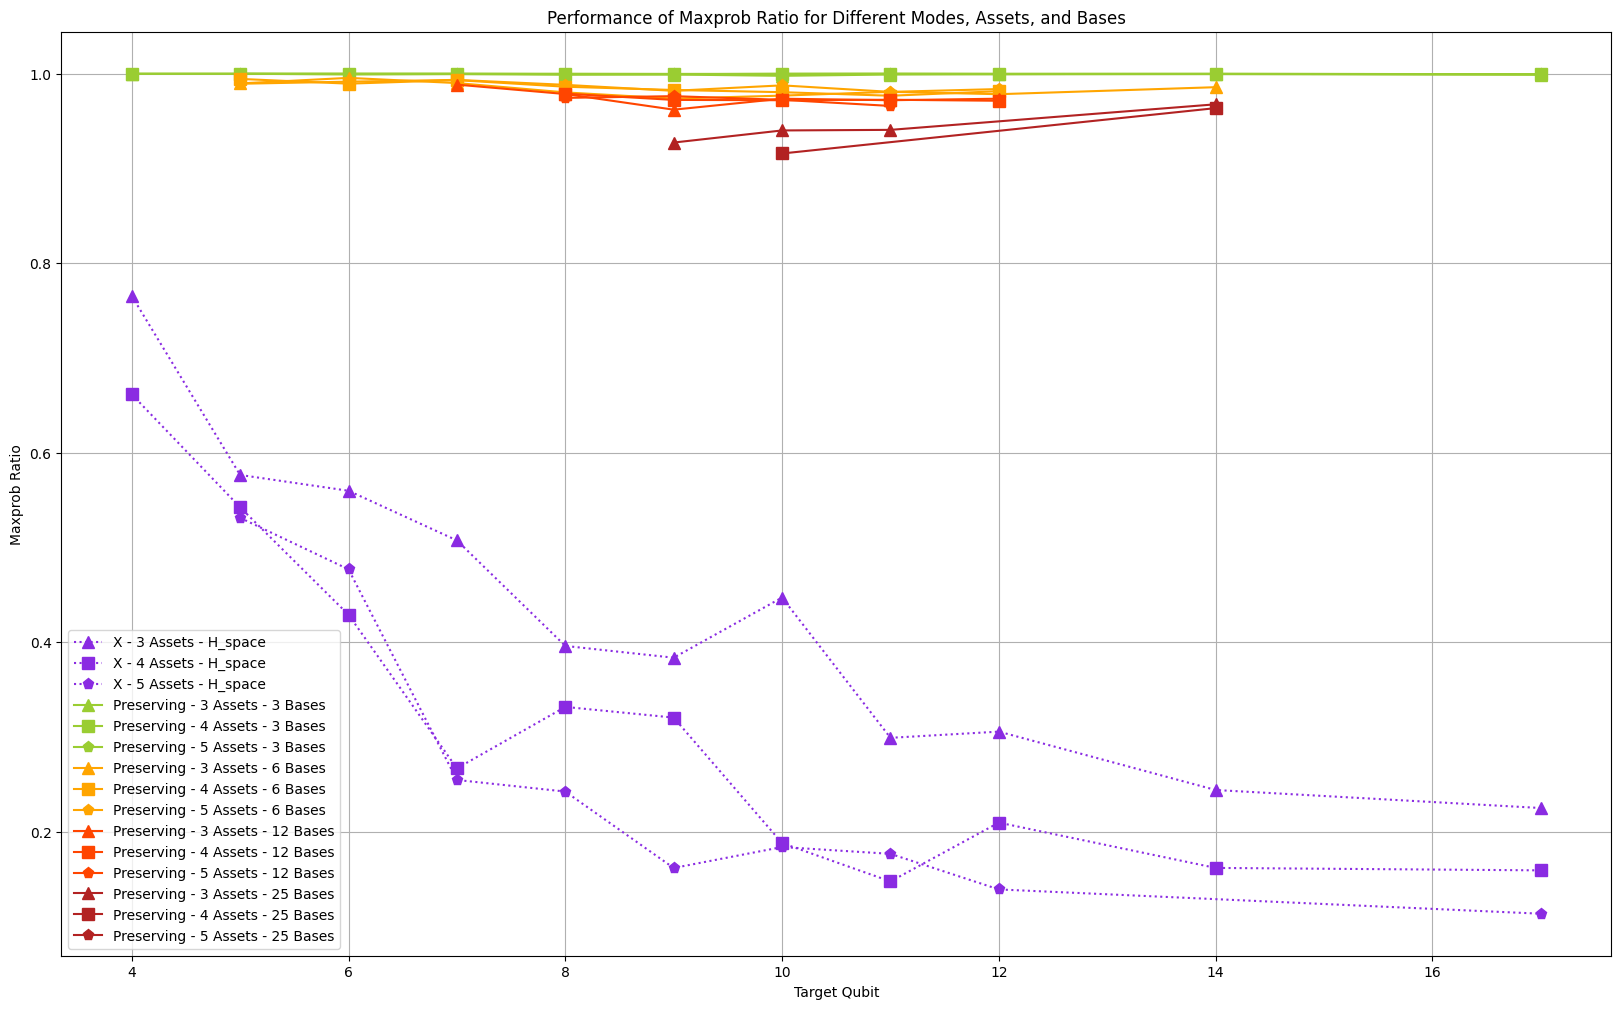

In [114]:
modes = ["X", "Preserving"]
LAMB = 4  # Budget Penalty
Q = 0  # Volatility Weight
marker_map = {3: "^", 4: "s", 5: "p"}
color_map = {(3, 'Preserving'): "yellowgreen",
                (6, 'Preserving'): "orange",
                (12, 'Preserving'): "orangered",
                (25, 'Preserving'): "firebrick",
                ("H_space", "X"): "blueviolet"}
line_map = {"X": ":", "Preserving": "-"}
plot_mode = ["Approximate_ratio", "MaxProb_ratio"][1]
plt.figure(figsize=(20, 12))
for mode in modes:
    for num_init_bases in (["H_space"] if mode == "X" else [3, 6, 12, 25]):
        for N_ASSETS in range(3, 6):
            mode_results = []
            range_qubit = []
            for TARGET_QUBIT in range(4, 20):
                if mode == "Preserving" and not validate_qubit_assets_numBases(TARGET_QUBIT, N_ASSETS, num_init_bases):
                    continue
                dir_name = f"exp_Q{TARGET_QUBIT}_A{N_ASSETS}_L{LAMB}_q{Q}_B{3 if mode == 'X' else num_init_bases}"
                dir_path = f"./experiments/{dir_name}"
                if not os.path.exists(f"{dir_path}/result.csv"):
                    continue
                df = pd.read_csv(f"{dir_path}/result.csv")
                mode_result = df[df["Mode"] == mode][plot_mode].values[0]
                mode_results.append(mode_result)
                range_qubit.append(TARGET_QUBIT)
            plt.plot(range_qubit, mode_results, marker=marker_map[N_ASSETS], color=color_map[(num_init_bases, mode)], linestyle=line_map[mode], label=f"{mode} - {N_ASSETS} Assets - {num_init_bases}{'' if mode == 'X' else ' Bases'}", markersize=8)
plt.xlabel("Target Qubit")
plt.ylabel(plot_mode.replace("_", " ").title())
plt.title(f"Performance of {plot_mode.replace('_', ' ').title()} for Different Modes, Assets, and Bases")
plt.legend()
plt.grid()
plt.show()

warm-start: near identity initialization



Text(0.5, 1.0, 'Loss for exp_Q14_A5_L4_q0_B12_bk: Preserving Mode')

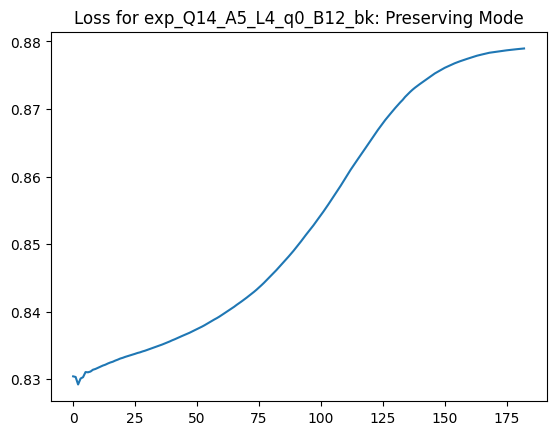

In [ ]:
dirr = "exp_Q14_A5_L4_q0_B12_bk"
mode = ["X", "Preserving"][1]
iterr = 0
dir_path = f"./experiments/{dirr}/expectations_{mode}/expectations_{iterr}.npy"

loss = np.load(dir_path)
plt.plot(loss)
plt.title(f"Loss for {dirr}: {mode} Mode")
# draw line


In [ ]:
dir_path_0 = "./experiments/exp_Q6_A5_L4_q0_B12/iter_states/0000.pkl"
dir_path_20 = "./experiments/exp_Q6_A5_L4_q0_B12/iter_states/0020.pkl"

state_0 = pickle.load(open(dir_path_0, "rb"))
state_20 = pickle.load(open(dir_path_20, "rb"))
print(state_0)
print(state_20)

('MT19937', array([2742806317, 2291976872, 1462698009, 1381182405, 1584100580,
        838901914, 2876076871, 3013668481,  226106661, 2535582910,
        927260742, 3284631078, 3008621903, 1568405459,  612195766,
       2882844463, 1837319114, 3246086717, 4148832732, 3892686995,
       4142168633, 1157166603,  971368150, 2572218685, 3540375925,
       2887524423,  709172398, 1162728746, 1812054953, 3171066277,
       1028458729, 2632098589, 4083543529, 3850923413, 4104856865,
       2817802583, 3466322298, 1259999180,  853957175, 3120998592,
       2327303364, 1683117060, 3343249218,  903723465, 1046360977,
       4001243907, 1242970692, 1395567262, 4001318564, 3516967006,
       3040326027, 2343537252,   85468611,   72034028, 4198079947,
       1270438095, 3263508825, 3805502393,  644353663, 1470994015,
       3982453518,  386855870, 2603906690, 2050976172, 3042559795,
       3648042349,  477878038,  981961108,  906315852, 3771149492,
       2872407554, 2231080654, 3231460793, 3683195

In [17]:
a = (cudaq.spin.x(1) + cudaq.spin.y(1)) * (cudaq.spin.x(0) + cudaq.spin.z(3))
print(a.term_count)
b = (cudaq.spin.x(0) * cudaq.spin.y(2))  + (cudaq.spin.x(0) + cudaq.spin.y(2) * cudaq.spin.i(1))
print(b.term_count, b)
b = b.canonicalize()
print(b.term_count, b)

4
3 (1+0i) * X0 + (1+0i) * I1Y2 + (1+0i) * X0Y2
3 (1+0i) * X0 + (1+0i) * Y2 + (1+0i) * X0Y2


In [13]:
print(-1 % 23)

22


In [36]:
N = 100
ddof = 1
aa = np.random.uniform(-1, 1, N)
print(aa.std()**2)
aa_sum = aa.sum()
aa_sum2 = (aa**2).sum()
print(aa_sum2 / N - (aa_sum / N)**2)

print(aa.std(ddof=1)**2)
print(aa_sum2 / (N - ddof) - aa_sum**2 / (N * (N - ddof)))

0.32422094728949896
0.32422094728949896
0.3274959063530292
0.3274959063530293
